In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


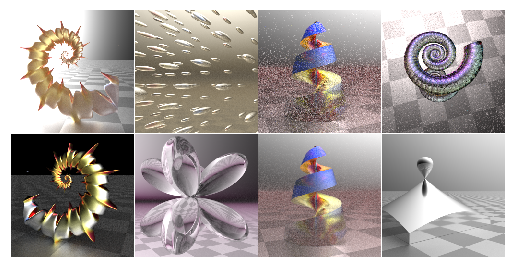

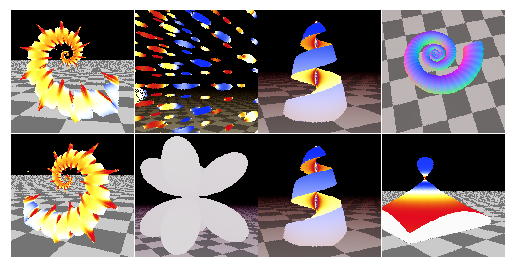

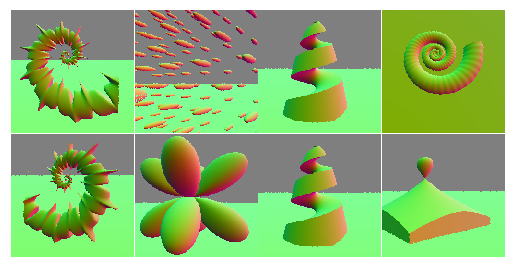

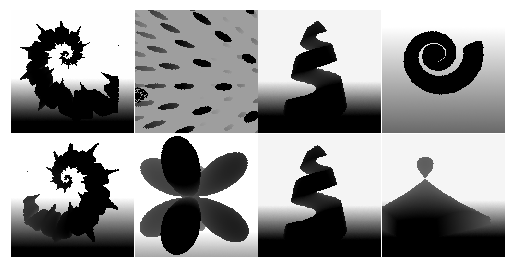

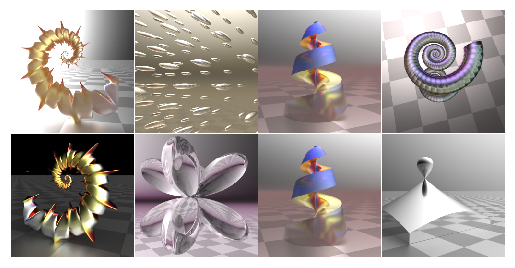

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True, padding_mode='reflect')

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True, padding_mode='reflect')

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 16
        n1 = 24
        n2 = 32
        n3 = 48
        n4 = 64
        # self.econv0 = conv3(10, n0) # 1
        self.econv0a = conv3(10, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.econv3 = conv3(n2, n3) # 1/8
        self.mconv1 = conv3(n3, n4) # 1/16
        self.mconv2 = conv3(n4, n4) # 1/16
        self.dconv3a = dconv4(n4, n3) # 1/16->1/8
        self.dconv3b = conv3(n3+n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        # self.dconv0b = conv3(n0+n0, 3) # 1
        self.dconv0b = conv3(n0+n0, n0) # 1
        self.dconv0 = conv3(n0, 3) # 1

    def forward(self, input):
        # e0 = self.econv0(input) # 1
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        e3 = self.econv3(pool(e2)) # 1/8
        m1 = self.mconv1(pool(e3)) # 1/16
        m2 = self.mconv2(relu(m1)) # 1/16
        d3 = relu(self.dconv3a(relu(m2))) # 1/8
        d3 = relu(self.dconv3b(concat(d3, e3))) # 1/8
        d2 = relu(self.dconv2a(d3)) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        d0 = relu(self.dconv0b(concat(d0, e0))) # 1
        # return d0
        # return d0 + input[:, :3]
        return self.dconv0(d0)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv0b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv1): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv2): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (mconv1): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (mconv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (dconv3a): ConvTranspose2d(64, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv3b): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (dconv2a): ConvTranspose2d(48, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): C

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
256 0.1402243673801422
512 0.11514154076576233
768 0.07129988819360733
1024 0.1118072122335434
1280 0.08602022379636765
1536 0.10618448257446289
1792 0.09957017004489899
2048 0.09564819186925888


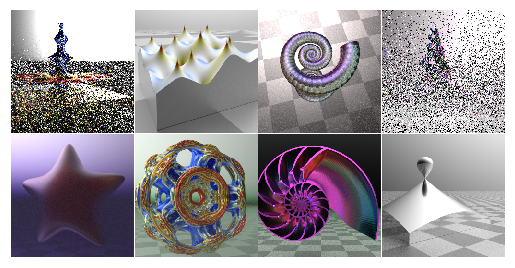

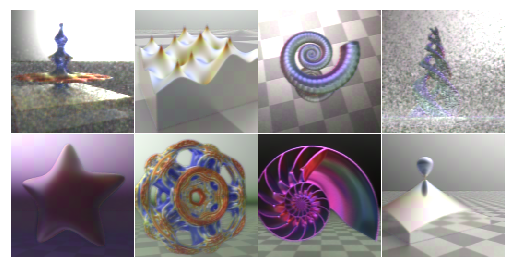

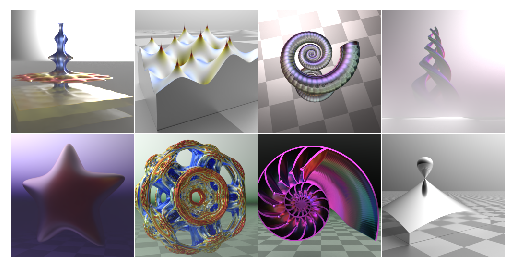

2304 0.10657332837581635
2560 0.08877819776535034
2816 0.13218814134597778
3072 0.07381119579076767
3328 0.08387897908687592
3584 0.09064054489135742
3840 0.0669669359922409
4096 0.07416079193353653


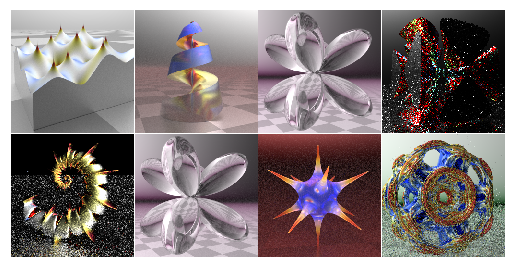

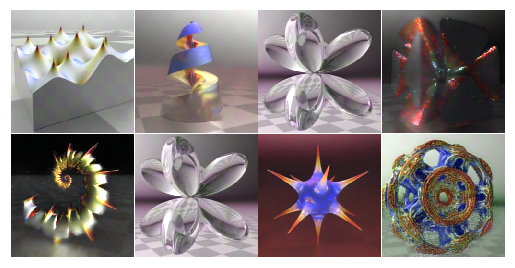

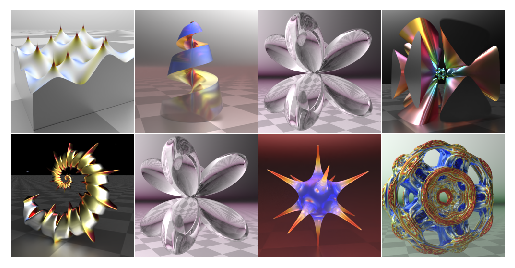

4352 0.08342896401882172
4608 0.042147159576416016
4864 0.061074189841747284
5120 0.10474684834480286
5376 0.05034355819225311
5632 0.06700104475021362
5888 0.039320208132267
6144 0.06801281124353409


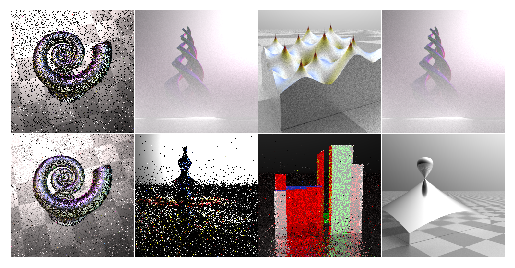

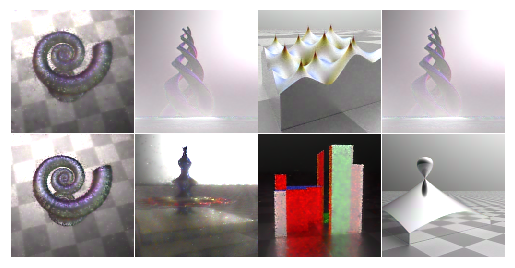

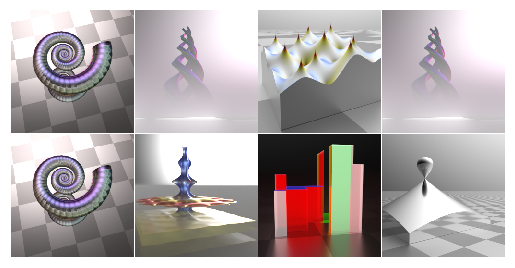

6400 0.06029394268989563
6656 0.054662417620420456
6912 0.05952874571084976
7168 0.056069087237119675
7424 0.04544949531555176
7680 0.03141455352306366
7936 0.05072186887264252
8192 0.04621927812695503


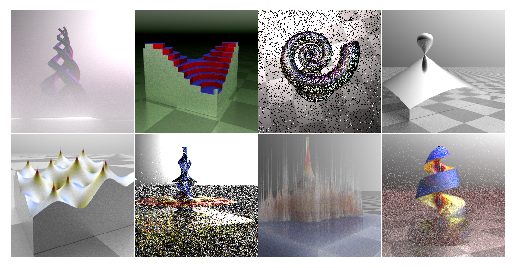

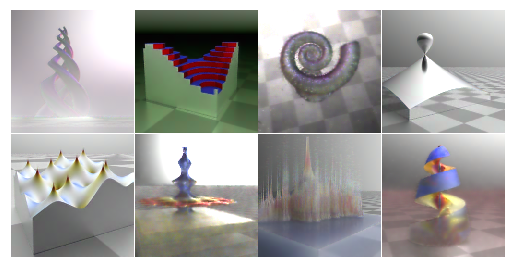

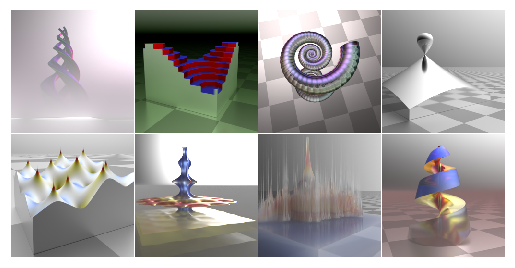

8448 0.04881555214524269
8704 0.039555225521326065
8960 0.037391312420368195
9216 0.039574332535266876
9472 0.055482421070337296
9728 0.06545212864875793
9984 0.052970726042985916
10240 0.047953274101018906


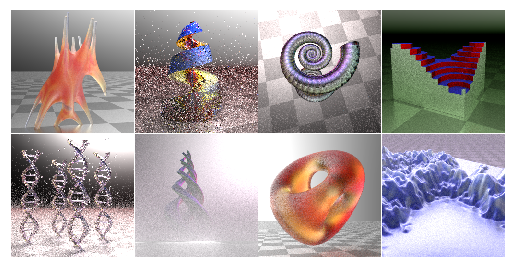

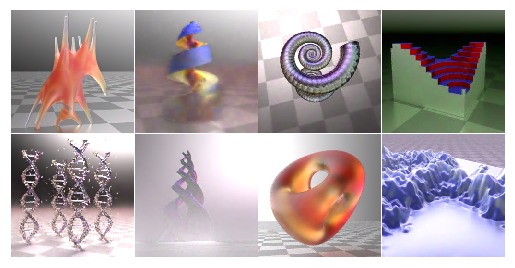

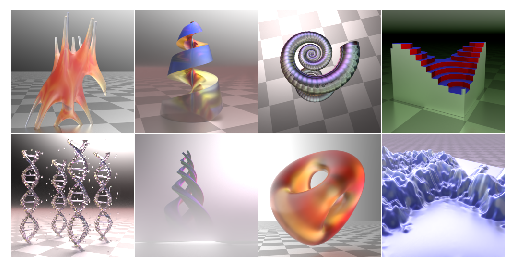

10496 0.055970706045627594
10752 0.07488948106765747
11008 0.03637676313519478
11264 0.046914197504520416
11520 0.057585202157497406
11776 0.046764809638261795
12032 0.06196221336722374
12288 0.05866416171193123


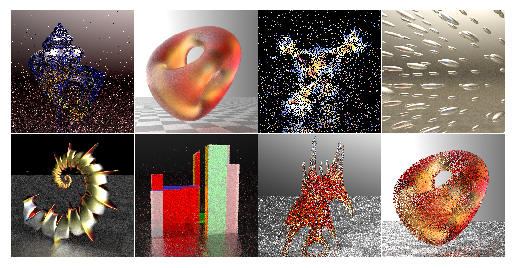

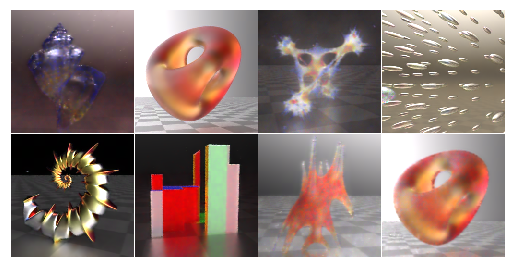

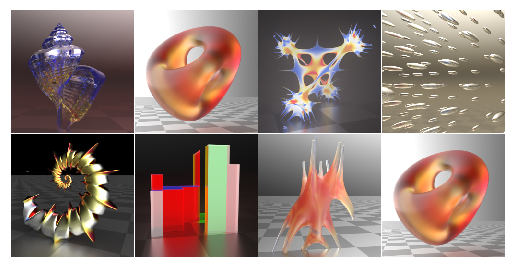

12544 0.02774195559322834
12800 0.034828219562768936
13056 0.053708840161561966
13312 0.027544543147087097
13568 0.0460018590092659
13824 0.05851367861032486
14080 0.045607153326272964
14336 0.04951300472021103


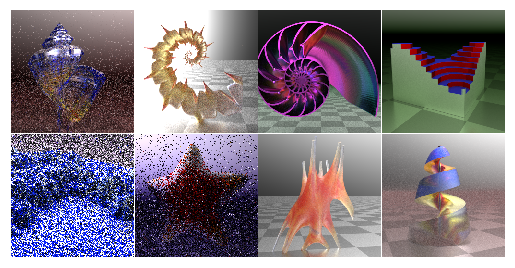

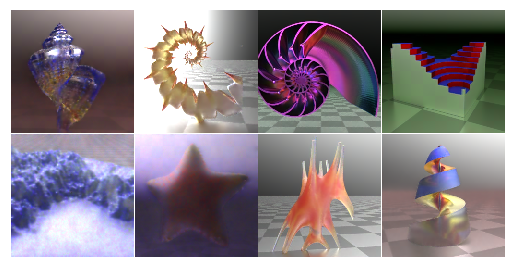

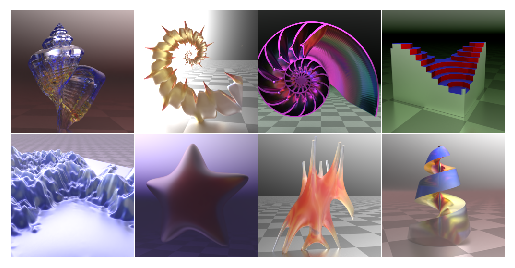

14592 0.0327223464846611
14848 0.03915270045399666
15104 0.04194663465023041
15360 0.056068986654281616
15616 0.04107885807752609
15872 0.031156228855252266
16128 0.05548539757728577
16384 0.03248585760593414


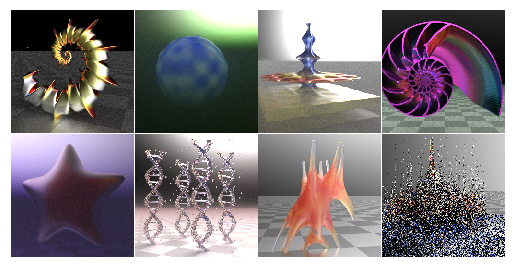

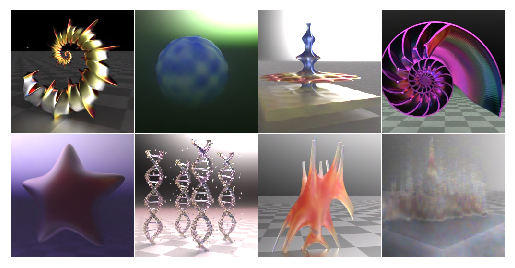

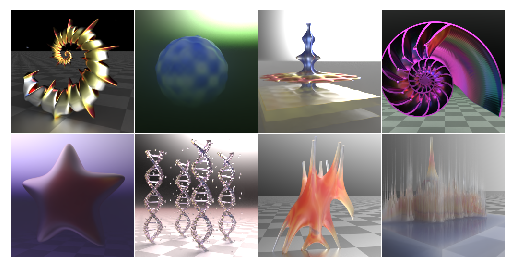

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

import torchvision.models
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
vgg16_features = vgg16.features
# vgg16_head = vgg16_features[:8].to(device)
vgg16_head = vgg16_features[:3].to(device)
print(vgg16_head)

def lossfun(output, reference, input):
    r1 = torch.mean(torch.abs(output-reference))
    r2 = torch.mean(torch.abs(vgg16_head(output)-vgg16_head(reference)))
    return r2
    return 0.5*r1 + 0.5*r2

batch_count = 0
for epoch in range(4):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        m_in = torch.concatenate((x, a), axis=1)
        output = model(m_in)
        loss = lossfun(output, y, x)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 256 == 0:
            print(batch_count, loss.item())
        if batch_count % 8192 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(output.detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model2.pth")